# Imports

In [259]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import torch.nn.functional as F
import numpy as np
import pickle
from sklearn.metrics import mean_absolute_error

# Settings

In [260]:
DAY_EVAL = True

# Load Data

In [261]:
# Load in the data
X1_train = pd.read_parquet('../../data/preprocessed/full_data.pq')
X1_test = pd.read_parquet('../../data/preprocessed/test_x.pq')
y1_train = pd.read_parquet('../../data/preprocessed/full_data_y.pq')
y1_test = pd.read_parquet('../../data/preprocessed/test_y.pq')

In [262]:
X1_test.columns

Index(['ProzessData_ActData_AB1_Analogs_DX1_MassPressure',
       'ProzessData_ActData_AB1_Analogs_GY1_MassLevelTank',
       'ProzessData_ActData_AB1_Current_DV1_Scraper',
       'ProzessData_ActData_AB1_Current_DW1_RiserPumpFwd',
       'ProzessData_ActData_AB1_Speed_DV1_Scraper',
       'ProzessData_ActData_AB1_Speed_DW1_RiserPumpFwd',
       'ProzessData_ActData_AB1_Temperature_DP1_MassHeatingStage',
       'ProzessData_ActData_AB1_Temperature_DP1_WaterHeatingStage',
       'ProzessData_ActData_AB1_Temperature_DQ1_MassCoolingStage',
       'ProzessData_ActData_AB1_Temperature_DQ1_WaterCoolingStage',
       'ProzessData_ActData_AB1_Temperature_DR1_WaterMixingStage',
       'ProzessData_ActData_AB1_Temperature_DS1_WaterPipe',
       'ProzessData_ActData_AB1_Temperature_DU1_WaterTank',
       'ProzessData_ActData_AB1_Temperature_DX1_MassInfeed'],
      dtype='object')

In [263]:
def add_time_features(df):
    df['hour'] = df.index.hour
    df['minute'] = df.index.minute
    daytime_arr = []
    for idx in df.index:
        if df.loc[idx, "hour"] == 4 and df.loc[idx, "minute"] >= 30:
            daytime_arr.append(1)
        elif df.loc[idx, "hour"] > 4 and df.loc[idx, "hour"] < 16:
            daytime_arr.append(1)
        elif df.loc[idx, "hour"] == 16 and df.loc[idx, "minute"] <= 40:
            daytime_arr.append(1)
        else:
            daytime_arr.append(0)

    df['day_time'] = daytime_arr
    df['night_time'] = 1 - df['day_time']
    return df

X1_test = add_time_features(X1_test)

In [264]:
X1_test.columns

Index(['ProzessData_ActData_AB1_Analogs_DX1_MassPressure',
       'ProzessData_ActData_AB1_Analogs_GY1_MassLevelTank',
       'ProzessData_ActData_AB1_Current_DV1_Scraper',
       'ProzessData_ActData_AB1_Current_DW1_RiserPumpFwd',
       'ProzessData_ActData_AB1_Speed_DV1_Scraper',
       'ProzessData_ActData_AB1_Speed_DW1_RiserPumpFwd',
       'ProzessData_ActData_AB1_Temperature_DP1_MassHeatingStage',
       'ProzessData_ActData_AB1_Temperature_DP1_WaterHeatingStage',
       'ProzessData_ActData_AB1_Temperature_DQ1_MassCoolingStage',
       'ProzessData_ActData_AB1_Temperature_DQ1_WaterCoolingStage',
       'ProzessData_ActData_AB1_Temperature_DR1_WaterMixingStage',
       'ProzessData_ActData_AB1_Temperature_DS1_WaterPipe',
       'ProzessData_ActData_AB1_Temperature_DU1_WaterTank',
       'ProzessData_ActData_AB1_Temperature_DX1_MassInfeed', 'hour', 'minute',
       'day_time', 'night_time'],
      dtype='object')

In [265]:
# Data for Day Model
X1_train_day = X1_train[X1_train['day_time'] == 1]
y1_train_day = y1_train[X1_train['day_time'] == 1]
X1_test_day = X1_test[X1_test['day_time'] == 1]
y1_test_day = y1_test[X1_test['day_time'] == 1]

# Data for Night Model
X1_train_night = X1_train[X1_train['day_time'] == 0]
y1_train_night = y1_train[X1_train['day_time'] == 0]
X1_test_night = X1_train[X1_train['day_time'] == 0]
y1_test_night = y1_train[X1_train['day_time'] == 0]

X1_train_day = X1_train_day.drop(columns=['day_time', 'night_time'])
X1_test_day = X1_test_day.drop(columns=['day_time', 'night_time'])
X1_train_night = X1_train_night.drop(columns=['day_time', 'night_time'])
X1_test_night = X1_test_night.drop(columns=['day_time', 'night_time'])

In [266]:
if DAY_EVAL:
    MODEL_PATH = "../../models/final_lstm_day.pth"
    train_x = X1_train_day
    train_y = y1_train_day
    test_x = X1_test_day
    test_y = y1_test_day
else:
    MODEL_PATH = "../../models/final_lstm_night.pth"
    train_x = X1_train_night
    train_y = y1_train_night
    test_x = X1_test_night
    test_y = y1_test_night

In [267]:
print(train_x.shape)
print(train_x.columns)
train_x = train_x.drop(columns=['hour', 'minute'])
print(train_x.shape)
print(train_x.columns)

(482460, 16)
Index(['ProzessData_ActData_AB1_Analogs_DX1_MassPressure',
       'ProzessData_ActData_AB1_Analogs_GY1_MassLevelTank',
       'ProzessData_ActData_AB1_Current_DV1_Scraper',
       'ProzessData_ActData_AB1_Current_DW1_RiserPumpFwd',
       'ProzessData_ActData_AB1_Speed_DV1_Scraper',
       'ProzessData_ActData_AB1_Speed_DW1_RiserPumpFwd',
       'ProzessData_ActData_AB1_Temperature_DP1_MassHeatingStage',
       'ProzessData_ActData_AB1_Temperature_DP1_WaterHeatingStage',
       'ProzessData_ActData_AB1_Temperature_DQ1_MassCoolingStage',
       'ProzessData_ActData_AB1_Temperature_DQ1_WaterCoolingStage',
       'ProzessData_ActData_AB1_Temperature_DR1_WaterMixingStage',
       'ProzessData_ActData_AB1_Temperature_DS1_WaterPipe',
       'ProzessData_ActData_AB1_Temperature_DU1_WaterTank',
       'ProzessData_ActData_AB1_Temperature_DX1_MassInfeed', 'hour', 'minute'],
      dtype='object')
(482460, 14)
Index(['ProzessData_ActData_AB1_Analogs_DX1_MassPressure',
       'Prozess

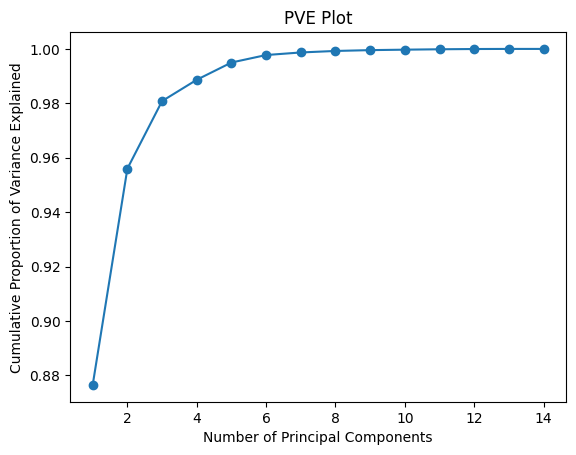

In [268]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
target_column = 'ProzessData_ActData_AB1_Temperature_DR1_MassMixingStage'

# Normalize features in train_x (excluding the timestamp column)
scaler_x = StandardScaler()
train_x_scaled = scaler_x.fit_transform(train_x.to_numpy())  # Adjust if the first column isn't the timestamp

# Perform PCA
pca = PCA()
X1_train_day_pca = pca.fit_transform(train_x_scaled)

# Calculate the proportion of variance explained
pve = pca.explained_variance_ratio_
cumulative_pve = np.cumsum(pve)

# Plot the PVE
plt.plot(range(1, len(pve) + 1), cumulative_pve, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Proportion of Variance Explained')
plt.title('PVE Plot')
plt.show()

In [269]:
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA(n_components=3)
train_x_pca = pca.fit_transform(train_x_scaled)

In [270]:
from sklearn.decomposition import PCA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
target_column = 'ProzessData_ActData_AB1_Temperature_DR1_MassMixingStage'

train_x_tensor = torch.tensor(train_x_pca).float().unsqueeze(1) # train_x_scaled

# scaler_y = StandardScaler()
# train_y_scaled = scaler_y.fit_transform(train_y[[target_column]])
train_y_tensor = torch.tensor(train_y.to_numpy()).float() # train_y_scaled | Night: test_y

# DataLoader
train_dataset = TensorDataset(train_x_tensor, train_y_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False) # changed to False

In [271]:
# Prefixed
input_dim = 3

# Goal: MAE: 0.0559
weight_decay=0.001
clip_value=6.480203110123226
hidden_dim=32
num_layers=3
dropout_rate=0.10901259861276512
lr=0.0006423716455944324
batch_size=32

## Load Trained Model

In [272]:
device = torch.device('cuda:0')

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout_rate):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout_rate)
        self.fc = nn.Linear(hidden_dim, 1) 

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out


# Load the dictionary
model_info = torch.load(MODEL_PATH)

# Extract the model state and the additional values
state_dict = model_info['state_dict']
input_dim = model_info['input_dim']
hidden_dim = model_info['hidden_dim']
num_layers = model_info['num_layers']
dropout_rate = model_info['dropout_rate']
output_dim = model_info['output_dim']

# Create a new model with the additional values
model = LSTMModel(input_dim, hidden_dim, num_layers, dropout_rate).to(device)
# model = LSTMModel(input_dim, hidden_dim, num_layers).to(device)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [273]:
test_x.shape

(131580, 16)

In [274]:
test_x = test_x.drop(columns=['hour', 'minute'])
test_x_scaled = scaler_x.transform(test_x.to_numpy())
test_x_pca = pca.transform(test_x_scaled)
test_x_tensor = torch.tensor(test_x_pca).float().unsqueeze(1).to(device)
predictions = model(test_x_tensor)
mae = mean_absolute_error(test_y, predictions.cpu().detach().numpy())
print('Mean Absolute Error:', mae)
print("Examples:")
print(predictions)
print(test_y)

Mean Absolute Error: 0.091283649506042
Examples:
tensor([[41.7585],
        [41.5156],
        [41.9818],
        ...,
        [41.5154],
        [41.5154],
        [41.5154]], device='cuda:0', grad_fn=<AddmmBackward0>)
                           ProzessData_ActData_AB1_Temperature_DR1_MassMixingStage
2023-04-11 04:30:00+00:00                                               41.5      
2023-04-11 04:30:01+00:00                                               41.5      
2023-04-11 04:30:02+00:00                                               41.5      
2023-04-11 04:30:03+00:00                                               41.5      
2023-04-11 04:30:04+00:00                                               41.5      
...                                                                      ...      
2023-04-13 16:40:55+00:00                                               41.5      
2023-04-13 16:40:56+00:00                                               41.5      
2023-04-13 16:40:57+00:00        

Day MAE: 0.071-0.105

Night MAE: 0.01